In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [30]:
class BB:
    
    def __init__(self, ticker='FB', period=21):
        self.ticker = ticker
        self.period = period
        self.df = None
        
    def download(self):
        stock = yf.Ticker(self.ticker)
        self.df = stock.history(period='max')
        
    def bb(self):
        self.df['ma'] = self.df.Close.rolling(window=self.period).mean()
        self.df['std'] = self.df.Close.rolling(window=self.period).std()
        self.df['upper'] = self.df['ma'] + self.df['std'] * 2
        self.df['lower'] = self.df['ma'] - self.df['std'] * 2
        
    def bb_signal_for_plot(self):
        self.df['buy'] = np.nan
        self.df['sell'] = np.nan
        buy_days = (self.df.Close < self.df.lower)
        self.df.loc[buy_days, 'buy'] = self.df.loc[buy_days, 'Close']
        sell_days = (self.df.Close > self.df.upper)
        self.df.loc[sell_days, 'sell'] = self.df.loc[sell_days, 'Close']
        
    def bb_signal_for_trade(self):
        self.df['signal'] = 0
        self.df.loc[self.df.Close < self.df.lower, 'signal'] = 1
        self.df.loc[self.df.Close > self.df.upper, 'signal'] = -1
        zip_obj = zip(self.df.index, self.df.signal)
        for idx, (date, signal) in enumerate(zip_obj):
            if idx == 0:
                previous_date = None
            # 처음에는 특별한 조치를 취하지 않음 (idx > self.period)
            if signal == 0 and idx > self.period:
                previous_signal = self.df.loc[previous_date, 'signal']
                self.df.loc[date, 'signal'] = previous_signal
            previous_date = date
    
    def bb_position(self):
        self.df['position'] = self.df.signal.shift()
    
    def compute_return(self):
        self.df['return'] = self.df.Close.pct_change()
        
    def compute_bb_return(self):
        self.df['bb_return'] = self.df['return'] * self.df.position
        
    def plot_bb(self, start, end):
        self.download()
        self.bb()
        self.bb_signal_for_plot()
        
        df = self.df.loc[start:end]
        date = df.index
        upper = df.upper
        lower = df.lower
        close = df.Close
        buy = df.buy
        sell = df.sell
        ma = df.ma
        
        fig = plt.figure()
        plt.fill_between(date, upper, lower, color='gray', alpha=0.3)
        plt.plot(date, close, c='k', lw=3, label='Close', alpha=0.3)
        plt.plot(date, ma, c='b', lw=3, label='MA', alpha=0.3)
        plt.scatter(date, buy, c='g', lw=3, marker='^', label='BUY')
        plt.scatter(date, sell, c='r', lw=3, marker='v', label='SELL')
        
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()
        
    def run(self, start, end):
        self.download()
        self.bb()
        self.bb_signal_for_plot()
        self.bb_signal_for_trade()
        self.bb_position()
        self.compute_return()
        self.compute_bb_return()
        
        df = self.df.loc[start:end]
        date = df.index
        upper = df.upper
        lower = df.lower
        close = df.Close
        buy = df.buy
        sell = df.sell
        ma = df.ma
        bb_return = df.bb_return
        bb_close = (1+bb_return.values).cumprod() * close[0]
        
        plt.fill_between(date, upper, lower, color='gray', alpha=0.3)
        plt.plot(date, close, c='k', lw=3, label='Close', alpha=0.3)
        plt.scatter(date, buy, c='g', lw=3, marker='^', label='BUY')
        plt.scatter(date, sell, c='r', lw=3, marker='v', label='SELL')
        
        plt.plot(date, bb_close, 'r', label='BB_Close')
        
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()
        
class BB_Long(BB):
    
    def bb_signal_for_trade(self):
        super().bb_signal_for_trade()
        self.df.loc[self.df.signal==-1, 'signal'] = 0
        
        

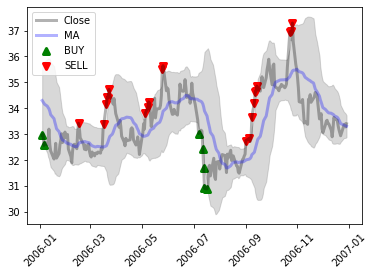

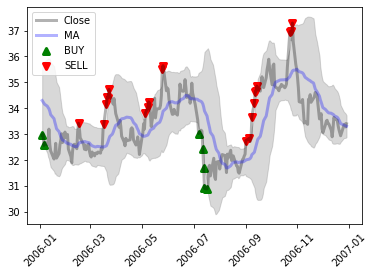

In [24]:
a = BB(ticker='WMT')
a.plot_bb('2006-01-01', '2006-12-31')
b = BB_Long(ticker='WMT')
b.plot_bb('2006-01-01', '2006-12-31')

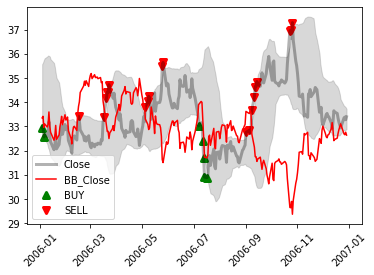

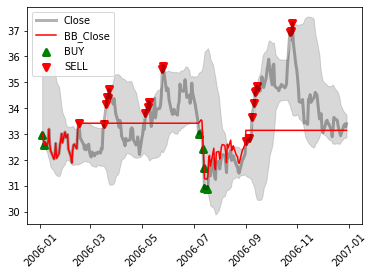

In [29]:
a = BB(ticker='WMT')
a.run('2006-01-01', '2006-12-31')
b = BB_Long(ticker='WMT')
b.run('2006-01-01', '2006-12-31')